<a href="https://colab.research.google.com/github/TrungPhan2106/Machine-learing/blob/master/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Đọc và chuẩn bị dữ liệu

In [2]:
data = pd.read_csv('/content/drive/MyDrive/ML/weather_forecast_data.csv')

print(data.head())
print(data.info())

# Chuyển đổi cột Rain thành số (0: no rain, 1: rain)
data['Rain'] = (data['Rain'] == 'rain').astype(int)

# Chuẩn bị dữ liệu
X = data[['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure']].values
y = data['Rain'].values

   Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
0    23.720338  89.592641    7.335604    50.501694  1032.378759     rain
1    27.879734  46.489704    5.952484     4.990053   992.614190  no rain
2    25.069084  83.072843    1.371992    14.855784  1007.231620  no rain
3    23.622080  74.367758    7.050551    67.255282   982.632013     rain
4    20.591370  96.858822    4.643921    47.676444   980.825142  no rain
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2500 non-null   float64
 1   Humidity     2500 non-null   float64
 2   Wind_Speed   2500 non-null   float64
 3   Cloud_Cover  2500 non-null   float64
 4   Pressure     2500 non-null   float64
 5   Rain         2500 non-null   object 
dtypes: float64(5), object(1)
memory usage: 117.3+ KB
None


Chuẩn hóa dữ liệu


In [3]:
def normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std, mean, std

X_normalized, mean_X, std_X = normalize(X)

# Thêm cột 1 vào ma trận X (bias term)
X_normalized = np.column_stack((np.ones(X_normalized.shape[0]), X_normalized))

# Chia dữ liệu thành tập train và test (80-20)
np.random.seed(42)
indices = np.random.permutation(len(X_normalized))
train_size = int(0.8 * len(X_normalized))

X_train = X_normalized[indices[:train_size]]
y_train = y[indices[:train_size]]
X_test = X_normalized[indices[train_size:]]
y_test = y[indices[train_size:]]


Triển khai Linear Regression

In [4]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        for _ in range(self.n_iterations):
            # Tính xác suất dự đoán
            y_pred = self.sigmoid(np.dot(X, self.weights))

            # Tính gradient
            gradient = (1 / n_samples) * np.dot(X.T, (y_pred - y))

            # Cập nhật weights
            self.weights -= self.learning_rate * gradient

            # Tính loss (log-loss)
            loss = -(1 / n_samples) * np.sum(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
            self.loss_history.append(loss)

    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.weights))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

Huấn luyện và đánh giá mô hình


Thống kê giá trị dự đoán trên tập train:
Min: 0.0000
Max: 0.9718
Mean: 0.1328

Weights của mô hình:
bias: -3.6231
Temperature: -1.2671
Humidity: 1.7244
Wind_Speed: -0.0499
Cloud_Cover: 1.5831
Pressure: 0.0539

Đánh giá trên tập train:
Accuracy: 0.9305
Precision: 0.8849
Recall: 0.5000
F1-Score: 0.6390

Đánh giá trên tập test:
Accuracy: 0.9280
Precision: 0.8636
Recall: 0.5588
F1-Score: 0.6786


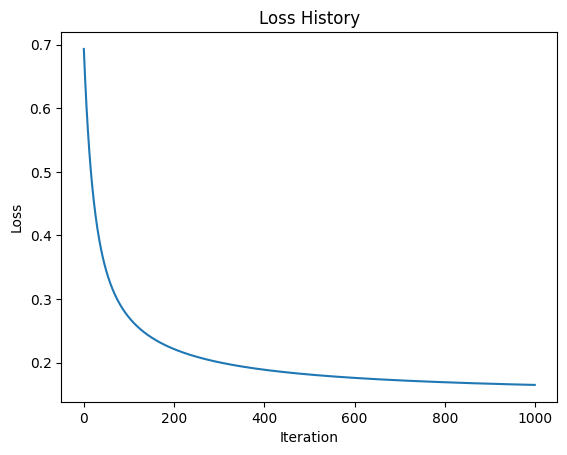

In [11]:
model = LogisticRegression(learning_rate=0.1, n_iterations=1000)
model.fit(X_train, y_train)

train_probabilities = model.predict_proba(X_train)
print("\nThống kê giá trị dự đoán trên tập train:")
print(f"Min: {train_probabilities.min():.4f}")
print(f"Max: {train_probabilities.max():.4f}")
print(f"Mean: {train_probabilities.mean():.4f}")

# Đánh giá mô hình
def evaluate(X, y, weights):
    y_pred = np.dot(X, weights)  # Dự đoán xác suất
    y_pred_binary = (y_pred >= 0.4).astype(int)  # Phân loại nhị phân

    # Tính các chỉ số
    true_positive = np.sum((y_pred_binary == 1) & (y == 1))
    false_positive = np.sum((y_pred_binary == 1) & (y == 0))
    false_negative = np.sum((y_pred_binary == 0) & (y == 1))

    # Precision, Recall và F1-Score
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Accuracy
    accuracy = np.mean(y_pred_binary == y)

    return accuracy, precision, recall, f1_score

# Tính các chỉ số trên tập train
train_accuracy, train_precision, train_recall, train_f1 = evaluate(X_train, y_train, model.weights)

# Tính các chỉ số trên tập test
test_accuracy, test_precision, test_recall, test_f1 = evaluate(X_test, y_test, model.weights)

# Hiển thị kết quả
print("\nWeights của mô hình:")
features = ['bias', 'Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure']
for f, w in zip(features, model.weights):
    print(f"{f}: {w:.4f}")

print("\nĐánh giá trên tập train:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

print("\nĐánh giá trên tập test:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Vẽ đồ thị loss
plt.plot(model.loss_history)
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Hàm dự đoán thời tiết cho dữ liệu mới

In [12]:
def predict_weather(temperature, humidity, wind_speed, cloud_cover, pressure):
    # Chuẩn hóa dữ liệu đầu vào
    input_data = np.array([temperature, humidity, wind_speed, cloud_cover, pressure])
    input_normalized = (input_data - mean_X) / std_X
    input_normalized = np.insert(input_normalized, 0, 1)  # Thêm bias term

    # Dự đoán
    probability = model.predict_proba(input_normalized)
    result = "Rain" if probability >= 0.4 else "No Rain"
    return probability, result

Dự đoán

In [17]:
print("Nhập các thông số thời tiết:")
temperature = float(input("Nhiệt độ (10-35°C): "))
humidity = float(input("Độ ẩm (30-100%): "))
wind_speed = float(input("Tốc độ gió (0-20km/h): "))
cloud_cover = float(input("Độ che phủ mây (0-100%): "))
pressure = float(input("Áp suất (980-1050 hPa): "))

# Dự đoán
probability, result = predict_weather(temperature, humidity, wind_speed, cloud_cover, pressure)

# Hiển thị kết quả
print("\nKết quả dự đoán:")
print(f"Nhiệt độ: {temperature:.2f}°C")
print(f"Độ ẩm: {humidity:.2f}%")
print(f"Tốc độ gió: {wind_speed:.2f} km/h")
print(f"Độ che phủ mây: {cloud_cover:.2f}%")
print(f"Áp suất: {pressure:.2f} hPa")
print(f"Giá trị dự đoán (Prediction): {probability:.4f}")
print(f"Kết luận: {result}")


Nhập các thông số thời tiết:
Nhiệt độ (10-35°C): 22
Độ ẩm (30-100%): 75
Tốc độ gió (0-20km/h): 8
Độ che phủ mây (0-100%): 80
Áp suất (980-1050 hPa): 1015

Kết quả dự đoán:
Nhiệt độ: 22.00°C
Độ ẩm: 75.00%
Tốc độ gió: 8.00 km/h
Độ che phủ mây: 80.00%
Áp suất: 1015.00 hPa
Giá trị dự đoán (Prediction): 0.2822
Kết luận: No Rain
